# Digital Signal and Image Processing Project - Image Retrieval

# Imports and Dataset

## Imports

In [1]:
from google.colab import drive
import zipfile
import shutil
import os
import numpy as np
import random as python_random
import matplotlib.pyplot as plt
import pandas as pd
import json

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from sklearn.neighbors import KDTree
from sklearn.metrics import accuracy_score, classification_report

from keras.layers import Input, Lambda
from keras.optimizers import Adam
from keras import backend as K
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, Activation
from keras.models import Sequential, Model
from keras.layers import ZeroPadding2D, Convolution2D, MaxPooling2D, Dropout, Flatten, Activation
from keras.optimizers import SGD
from keras.utils import to_categorical
from keras.preprocessing import image
from keras import applications
import numpy as np
from IPython.core.display import Image
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras import layers, Model
from tensorflow.keras.metrics import Metric
from scipy.spatial.distance import cdist
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler

np.random.seed(0)
python_random.seed(0)
tf.random.set_seed(0)
keras.utils.set_random_seed(0)
drive.mount('/content/drive')

Mounted at /content/drive


## Dataset Import and Split

The folder "dataset" is created which contains 3 sub folders for the 3 splits. The images are still divided by category.

Dictionaries are used to map label indices to their corresponding category names and vice versa.

In [2]:
# Transfer dataset, and extract files
shutil.copy('/content/drive/My Drive/MammalsDataset.zip', 'MammalsDataset.zip')
zipf = zipfile.ZipFile('MammalsDataset.zip')
zipf.extractall()
zipf.close()

os.remove('MammalsDataset.zip') # Delete the copied zip file

In [3]:
dataset_origin_path = "mammals"
dataset_path = "dataset"
train_ratio, val_ratio, test_ratio = 0.6, 0.2, 0.2

# Create destination directories
for split in ['train', 'val', 'test']:
    split_path = os.path.join(dataset_path, split)
    os.makedirs(split_path, exist_ok=True)

# Iterate through each category (sub-folder)
for category in sorted(os.listdir(dataset_origin_path)):
    category_path = os.path.join(dataset_origin_path, category)

    images = sorted(os.listdir(category_path))
    python_random.seed(0)
    python_random.shuffle(images)

    train_end = int(train_ratio * len(images))
    val_end = train_end + int(val_ratio * len(images))

    splits = {
        'train': images[:train_end],
        'val': images[train_end:val_end],
        'test': images[val_end:]
    }

    # Move images to respective directories
    for split, split_images in splits.items():
        split_category_path = os.path.join(dataset_path, split, category)
        os.makedirs(split_category_path, exist_ok=True)

        for img in split_images:
            shutil.move(os.path.join(category_path, img), os.path.join(split_category_path, img))

    # Remove empty category folder
    os.rmdir(category_path)

# Remove the original dataset folder if empty
if not os.listdir(dataset_origin_path):
    os.rmdir(dataset_origin_path)

print("Dataset split completed successfully.")


Dataset split completed successfully.


Dictionaries are created in order to map label indices to their corresponding category names and vice versa, whenever this will be needed later in the project.

In [4]:
category_names = sorted([d for d in os.listdir(dataset_path + "/train") if os.path.isdir(os.path.join(dataset_path + "/train", d))])
category_to_index = {name: i for i, name in enumerate(category_names)}
index_to_category = {i: name for name, i in category_to_index.items()}

# Import models & Features

In this section we load our best performing models and setup some functions for retrival.

## Functions

In [5]:
def triplet_loss(margin=0.1):
    """
    necessary for loading siames model
    """
    def loss(y_true, y_pred):
        anchor, positive, negative = y_pred[:, 0, :], y_pred[:, 1, :], y_pred[:, 2, :]
        pos_dist = tf.reduce_sum(tf.square(anchor - positive), axis=1)
        neg_dist = tf.reduce_sum(tf.square(anchor - negative), axis=1)
        loss = tf.maximum(pos_dist - neg_dist + margin, 0.0)
        return tf.reduce_mean(loss)

    return loss

In [6]:
def extract_features(model, root_folder, category_to_index, preprocess_function, image_size=(224, 224)):
    """
    Extract features from images in a root folder organized into subfolders by labels.
    Returns the features, the labels, and the corresponding image paths.
    """
    features = []
    labels = []
    image_paths = []

    for category in sorted(os.listdir(root_folder)):
        category_path = os.path.join(root_folder, category)
        print("Processing folder", category_path)

        if os.path.isdir(category_path):
            if category not in category_to_index:
                print(f"Skipping folder '{category}' as it is not in the category mapping.")
                continue

            label = category_to_index[category]  # Convert category name to label index

            image_files = [fname for fname in os.listdir(category_path) if fname.lower().endswith(('jpg', 'jpeg', 'png'))]

            for fname in image_files:
                image_path = os.path.join(category_path, fname)

                image = load_img(image_path, target_size=image_size)
                image_array = img_to_array(image)
                image_array = preprocess_function(image_array)
                image_array = np.expand_dims(image_array, axis=0)

                feature = model.predict(image_array, verbose=0)

                features.append(feature.flatten())
                labels.append(label)
                image_paths.append(image_path)

    return np.array(features), np.array(labels), image_paths

In [7]:
def load_or_compute_features(model, features_path, labels_path, paths_path, images_folder, category_to_index, preprocess_function=preprocess_input):
    """
    This function loads the saved features, labels and image paths (if available),
    otherwise it computes, saves them and returns them.
    """
    # Check if the feature, label, and image path files exist
    if os.path.exists(features_path):
        # Load the files if they exist
        train_features = np.load(features_path)
        train_labels = np.load(labels_path)
        train_image_paths = list(np.load(paths_path, allow_pickle=True))
        print("Loaded existing files.")
    else:
        # Otherwise, compute them
        print("Files missing, computing features...")
        train_features, train_labels, train_image_paths = extract_features(model, images_folder, category_to_index, preprocess_function)

        # Create the folder if it doesn't exist already
        features_save_folder = os.path.dirname(features_path)
        if not os.path.exists(features_save_folder):
            os.makedirs(features_save_folder)

        # Save the computed features, labels, and image paths
        np.save(features_path, train_features)
        np.save(labels_path, train_labels)
        np.save(paths_path, train_image_paths)
        print("Computed and saved new features.")

    return train_features, train_labels, train_image_paths

## Loading MobileNet model & features

In following section we laod mobileNet model and retrive it's previosly computed features, in this way we can later process input images as queries

### Loading model

In [8]:
# Load of MobileNetV2 without the top layer
mobilenet = MobileNetV2(weights="imagenet", include_top=False, pooling="avg", input_shape=(224, 224, 3))

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


### Loading features

In [9]:
dataset_train_path = dataset_path + "/train"
prefix = "/content/drive/My Drive/" #""
train_features_path = prefix + "IR Saves/Pre-Trained Approach/train_features.npy"
train_labels_path = prefix + "IR Saves/Pre-Trained Approach/train_labels.npy"
train_image_names_path = prefix + "IR Saves/Pre-Trained Approach/train_image_names.npy"

train_features, train_labels, train_image_paths = load_or_compute_features(mobilenet, train_features_path, train_labels_path, train_image_names_path, dataset_train_path, category_to_index)

Loaded existing files.


In [10]:
dataset_test_path = dataset_path + "/test"
test_features_path = prefix + "IR Saves/Pre-Trained Approach/test_features.npy"
test_labels_path = prefix + "IR Saves/Pre-Trained Approach/test_labels.npy"
test_image_names_path = prefix + "IR Saves/Pre-Trained Approach/test_image_names.npy"

test_features, test_labels, test_image_paths = load_or_compute_features(mobilenet, test_features_path, test_labels_path, test_image_names_path, dataset_test_path, category_to_index)

Loaded existing files.


## Loading best siamese model & features

In following section we laod siamese model with triplette loss and retrive it's previosly computed features. In this way we can later process input images as queries

### Loading model

In [11]:
# Define the load/save path (the folder)
model_folder = "/content/drive/My Drive/IR Saves/SiameseNetwork2 Approach"

# Create the folder if it doesn't exist
os.makedirs(model_folder, exist_ok=True)

# Define the full file paths
siamese_model_file = os.path.join(model_folder, "siamese_model2.keras")
encoder_model_file = os.path.join(model_folder, "encoder_model2.keras")

# Check if model files exist
if os.path.exists(siamese_model_file) and os.path.exists(encoder_model_file):
    # Load the models
    siamese_model2 = keras.models.load_model(siamese_model_file, custom_objects={'loss': triplet_loss()},safe_mode=False)
    encoder2 = keras.models.load_model(encoder_model_file,safe_mode=False)
    print("Models loaded successfully from Google Drive.")
else:
    # Build and train the models
    print("Models not found. Please upload files to Drive...")

Models loaded successfully from Google Drive.


### Loading features

In [12]:
prefix = "/content/drive/My Drive/" #

In [13]:
dataset_train_path = dataset_path + "/train"
train_features_path = prefix+"IR Saves/SiameseNetwork2 Approach/train_features.npy"
train_labels_path = prefix+"IR Saves/SiameseNetwork2 Approach/train_labels.npy"
train_image_names_path = prefix+"IR Saves/SiameseNetwork2 Approach/train_image_names.npy"

train_features_siamese2 , train_labels_siamese2, train_image_paths_siamese2 = load_or_compute_features(encoder2, train_features_path, train_labels_path, train_image_names_path, dataset_train_path, category_to_index)

Loaded existing files.


In [14]:
dataset_test_path = dataset_path + "/test"
test_features_path = prefix+"IR Saves/SiameseNetwork2 Approach/test_features.npy"
test_labels_path = prefix+"IR Saves/SiameseNetwork2 Approach/test_labels.npy"
test_image_names_path = prefix+"IR Saves/SiameseNetwork2 Approach/test_image_names.npy"

test_features_siamese2, test_labels_siamese2, test_image_paths_siamese2 = load_or_compute_features(encoder2, test_features_path, test_labels_path, test_image_names_path, dataset_test_path, category_to_index)

Loaded existing files.


## Laoding combined model and features

To combine the two methods, we simply normalized each array of feature arrays and concatenated them.

### Loading features

In [15]:
scaler = MinMaxScaler()

In [16]:
# Normalize features
normalized_train_features = scaler.fit_transform(train_features)
normalized_train_features_siamese2 = scaler.fit_transform(train_features_siamese2)

# Create a mapping from image paths to normalized features for train_features_siamese2
siamese2_dict = {path: feat for path, feat in zip(train_image_paths_siamese2, normalized_train_features_siamese2)}

# Align features using train_image_paths
aligned_train_features_siamese2 = np.array([siamese2_dict[path] if path in siamese2_dict else np.zeros_like(normalized_train_features_siamese2[0]) for path in train_image_paths])

# Horizontally stack the aligned features
combined_train_features = np.hstack((normalized_train_features, aligned_train_features_siamese2))

In [17]:
# Normalize features
normalized_test_features = scaler.fit_transform(test_features)
normalized_test_features_siamese2 = scaler.fit_transform(test_features_siamese2)

# Create a mapping from image paths to normalized features for test_features_siamese2
siamese2_dict = {path: feat for path, feat in zip(test_image_paths_siamese2, normalized_test_features_siamese2)}

# Align features using test_image_paths
aligned_test_features_siamese2 = np.array([siamese2_dict[path] if path in siamese2_dict else np.zeros_like(normalized_test_features_siamese2[0]) for path in test_image_paths])

# Horizontally stack the aligned features
combined_test_features = np.hstack((normalized_test_features, aligned_test_features_siamese2))

# Image Retrieval
This section creates the kd-trees, those are use to navigate trough feateures map and find nearest query images. In this way we can see how the features processed from each model (for input image) can be associated with previously evaluated feateures.

Select here which image you would like to load:

In [18]:
def find_image_index(image_list, image_name):
    for i, path in enumerate(image_list):
        if image_name in path:
            return i
    return -1

In [19]:
test_image_indices = [find_image_index(test_image_paths, "african_elephant-026")] # CHANGE IMAGES HERE

In [20]:
#### SOME INTRESTING IMAGES SUGGESTIONS
# 0. horse-0009 (just a very clear picture of an horse)
# 1. african_elephant-0049 (contains a lot of people that work as uotliers)
# 2. badger-0123 (it's a 3d model of a badjer, not a real one)
# 3. african_elephant-0001 (clear picture of an elephant -  one of best perfoming classes)
# 3. seal-0163 (just a seal but "seal" it's one of the most cosnistent underperfoming class, here we can see there are many similiar animals)

In [21]:
test_image_indices

[36]

## Functions

In [22]:
def print_retrieved_images(train_image_paths, test_image_paths, test_image_indices, query_indexes, query_distances, return_indices=False):
    """
    Plots the query image and its k nearest neighbors for each test image.
    If return_indices is True, returns the indices of the train images that were retrieved and plotted.
    """
    # Number of test images to plot
    num_test_images = len(test_image_indices)

    # Number of nearest neighbors to display
    k = len(query_indexes[0])

    # Adjust the figsize dynamically based on the number of images to display horizontally
    fig_width = 3 * (k + 1)  # 1 for the query image and k for neighbors
    fig_height = 3 * num_test_images  # 3 units of height per image row

    # Set up the plot with multiple rows (one for each test image) and (k + 1) columns (1 for the query image and k for neighbors)
    fig, axes = plt.subplots(num_test_images, k + 1, figsize=(fig_width, fig_height))

    # List to store the indices of the retrieved train images (only used if return_indices is True)
    retrieved_indices = []

    # Loop over each test image index
    for i, test_image_index in enumerate(test_image_indices):
        # Get the test image
        test_image_path = test_image_paths[test_image_index]
        test_image = load_img(test_image_path)

        # Extract category (folder name) and image name for the test image
        test_image_category = os.path.basename(os.path.dirname(test_image_path))
        test_image_name = os.path.basename(test_image_path)

        if (len(test_image_indices) != 1):
            # Plot the test image (query)
            axes[i, 0].imshow(test_image)
            axes[i, 0].set_title(f"Query:\n {test_image_name}")
            axes[i, 0].axis('off')  # Hide axes for the image
        else:
            # Plot the test image (query)
            axes[0].imshow(test_image)
            axes[0].set_title(f"Query:\n {test_image_name}")
            axes[0].axis('off')  # Hide axes for the image

        # Plot the k nearest images
        for j, (index, dist) in enumerate(zip(query_indexes[i], query_distances[i])):
            # Load the neighbor image
            neighbor_image_path = train_image_paths[index]
            neighbor_image = load_img(neighbor_image_path)

            # Extract the category (folder name) and name for the neighbor image
            neighbor_category = os.path.basename(os.path.dirname(neighbor_image_path))
            neighbor_name = os.path.basename(neighbor_image_path)

            if (len(test_image_indices) != 1):
                # Plot the neighbor image
                axes[i, j + 1].imshow(neighbor_image)
                axes[i, j + 1].set_title(f"{neighbor_name}\n(Dist: {dist:.2f})")
                axes[i, j + 1].axis('off')  # Hide axes for the image
            else:
                # Plot the neighbor image
                axes[j + 1].imshow(neighbor_image)
                axes[j + 1].set_title(f"{neighbor_name}\n(Dist: {dist:.2f})")
                axes[j + 1].axis('off')  # Hide axes for the image

            # Append the index of the retrieved train image to the list if return_indices is True
            if return_indices:
                retrieved_indices.append(index)

    plt.tight_layout()
    plt.show()

    # Return the list of retrieved train image indices only if return_indices is True
    if return_indices:
        return retrieved_indices

In [23]:
def calculate_anmrr(query_indexes, test_labels, train_labels, k=3):
    """
    Calculate Average Normalized Modified Retrieval Rank (ANMRR)s.
    """
    tests_number = len(query_indexes)  # Number of queries
    total_score = 0

    for i, query_index in enumerate(query_indexes):
        true_label = test_labels[i]  # True label of the current query

        # Get the labels of the k nearest neighbors
        neighbor_labels = train_labels[query_index]

        # Compute AVR(q) - the average rank of relevant documents
        relevant_ranks = []
        for rank, neighbor_label in enumerate(neighbor_labels):
            if neighbor_label == true_label:
                relevant_ranks.append(rank + 1)  # Add 1 to convert from 0-indexed to 1-indexed rank

        if relevant_ranks:
            average_rank_relevant_documents = np.mean(relevant_ranks)  # Average rank of relevant documents
        else:
            average_rank_relevant_documents = k + 1  # If no relevant documents found, set to K + 1

        # Calculate the ANMRR for the query
        number_relevant_documents = 1
        denominator = 1.25 * k - 0.5 * (1 + number_relevant_documents)
        if denominator == 0:  # Handle case when the denominator becomes zero
            continue  # Skip this query, as division by zero is not valid

        score = (average_rank_relevant_documents - 0.5 * (1 + number_relevant_documents)) / denominator
        total_score += score

    # Return the final ANMRR score
    ANMRR = total_score / tests_number
    return ANMRR

In [24]:
def retrieve_and_evaluate_category(kd_tree, category_name, num_images, root_test_folder, category_to_index, test_features):
    """
    Retrieves and evaluates images for a specific category using a KD-Tree.
    """

    print(f"Retrieving images for category {category_name}...")

    # Get the category index from the category name using the category_to_index mapping
    if category_name not in category_to_index:
        raise ValueError(f"Category '{category_name}' not found in the category_to_index mapping.")

    category_index = category_to_index[category_name]

    # Find indices of test images belonging to the specified category
    test_image_indices = [i for i, label in enumerate(test_labels) if label == category_index]

    # Limit the number of images to num_images (if available)
    test_image_indices = test_image_indices[:min(num_images, len(test_image_indices))]

    # Extract features for the selected test images
    test_images = test_features[test_image_indices]

    # Perform k-NN search using the KD-Tree
    k = 3  # Number of neighbors to retrieve
    query_distances, query_indexes = kd_tree.query(test_images, k=k)

    # Print retrieved images
    print_retrieved_images(train_image_paths, test_image_paths, test_image_indices, query_indexes, query_distances)

    # Calculate and print ANMRR
    anmrr_value = calculate_anmrr(query_indexes, test_labels[test_image_indices], train_labels, k=k)
    print(f"ANMRR for category {category_name}: {anmrr_value:.4f}")

## KD-Tree for MobileNet

The kd-tree is created on the train fetures that were extracted earlier; it will be used to retrived most similiar features extracted from query image using mobileNet.

In [25]:
kd_tree = KDTree(train_features)

The images are picked with 3 random indices, and their respective feature arrays are retrieved.

In [26]:
test_images = test_features[test_image_indices]
test_images.shape

(1, 1280)

5 images are retrieved for each one of the test image selected:

In [27]:
distances, indices = kd_tree.query(test_images, k=5)

This function takes the result of the kd-tree query and displays dynamically the original image and all of the retrieved images, with useful informations displayed in the titles.

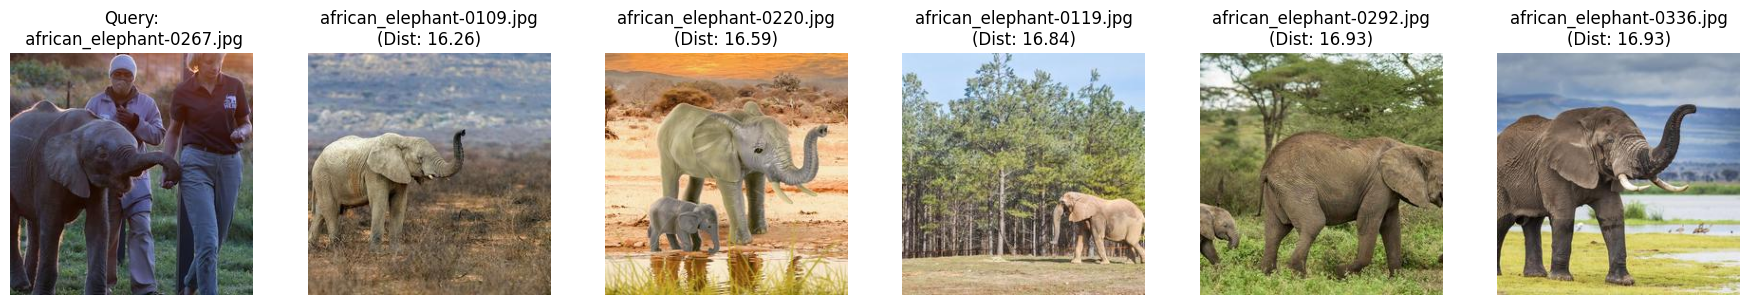

In [28]:
print_retrieved_images(train_image_paths, test_image_paths, test_image_indices, indices, distances) #2 param: file_list

## KD-Tree for Triplet loss Siamese Network

In [29]:
kd_tree_siamese2 = KDTree(train_features_siamese2)

The images are picked with the same exact random indices as before, and their respective feature arrays are retrieved.

In [30]:
test_images_siamese2 = test_features_siamese2[test_image_indices]
test_images_siamese2.shape

(1, 1280)

5 images are retrieved for each one of the 3 test images.

In [31]:
distances_siamese2, indices_siamese2 = kd_tree_siamese2.query(test_images_siamese2, k=5)

This function takes the result of the kd-tree query and displays dynamically the original image and all of the retrieved images, with useful informations displayed in the titles.

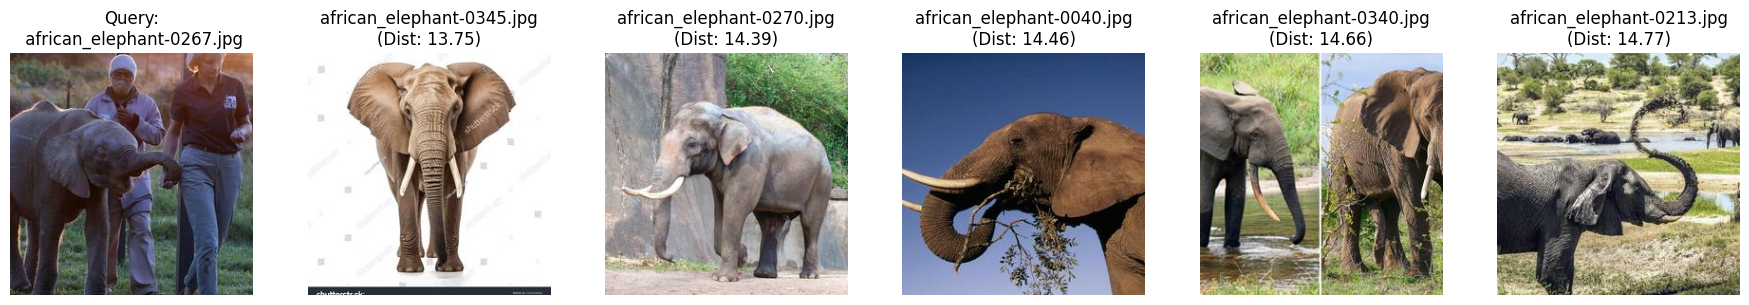

In [32]:
print_retrieved_images(train_image_paths, test_image_paths, test_image_indices, indices_siamese2, distances_siamese2) #2 param: file_list

## KD-Tree for combination model

The kd-tree is created on the combined train fearutures of both previous attempts. This should allow model to reache

In [33]:
kd_tree_combined = KDTree(combined_train_features)

The images are picked with 3 random indices, and their respective feature arrays are retrieved.

In [34]:
test_images = combined_test_features[test_image_indices]
test_images.shape

(1, 2560)

5 images are retrieved for each one of the test image selected:

In [35]:
query_distances_combined, query_indexes_combined = kd_tree_combined.query(test_images, k=5)

This function takes the result of the kd-tree query and displays dynamically the original image and all of the retrieved images, with useful informations displayed in the titles.

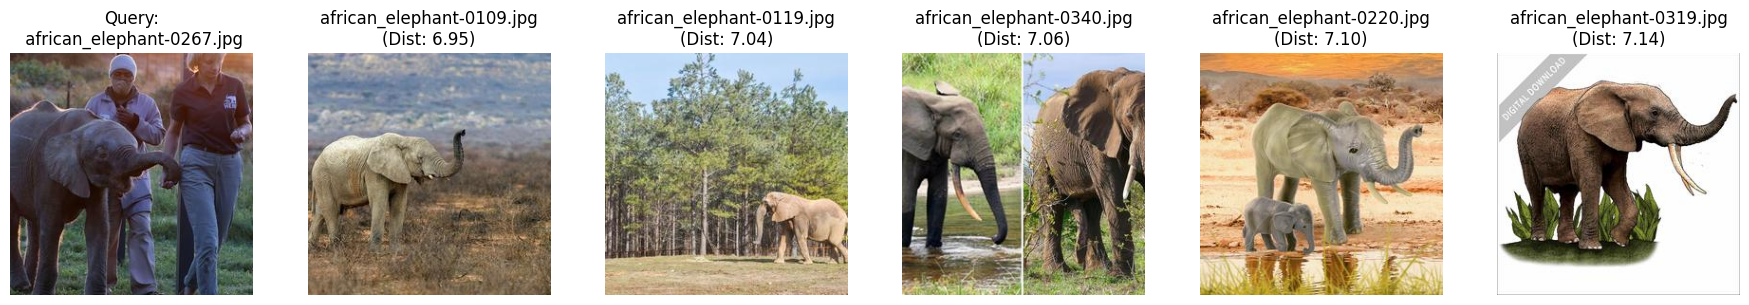

In [36]:
print_retrieved_images(train_image_paths, test_image_paths, test_image_indices, query_indexes_combined, query_distances_combined)

## Relevance feedback

Lastly, we used a strong relevance feedback to improve the returned images, testing on the worst class

First, we looked for the indexes of the test images for the class sea_lion, which is the worst performing class of the combined method.

In [37]:
def find_indices_by_category(test_labels, category_name, category_to_index):
  """
  Finds the indices of images belonging to a specific category.
  """
  if category_name not in category_to_index:
      print(f"Category '{category_name}' not found in category_to_index.")
      return []

  target_index = category_to_index[category_name]
  indices = np.where(np.array(test_labels) == target_index)[0].tolist()
  return indices

sea_lion_indices = find_indices_by_category(test_labels_siamese2, "sea_lion", category_to_index)
print(f"Indices of sea_lion images: {sea_lion_indices}")

Indices of sea_lion images: [1845, 1846, 1847, 1848, 1849, 1850, 1851, 1852, 1853, 1854, 1855, 1856, 1857, 1858, 1859, 1860, 1861, 1862, 1863, 1864, 1865, 1866, 1867, 1868, 1869, 1870, 1871, 1872, 1873, 1874, 1875, 1876, 1877, 1878, 1879, 1880, 1881, 1882, 1883, 1884, 1885, 1886, 1887, 1888, 1889, 1890, 1891, 1892, 1893, 1894, 1895, 1896, 1897, 1898, 1899, 1900, 1901, 1902, 1903, 1904, 1905, 1906, 1907, 1908, 1909, 1910, 1911, 1912]


Let's take the first image and return 10 images

In [38]:
test_image_indices = [1845]
test_images = combined_test_features[test_image_indices]
test_images.shape

(1, 2560)

In [39]:
distances, indices = kd_tree_combined.query(test_images, k=10)

We can see that only 5 of the 10 returned images are from the right class

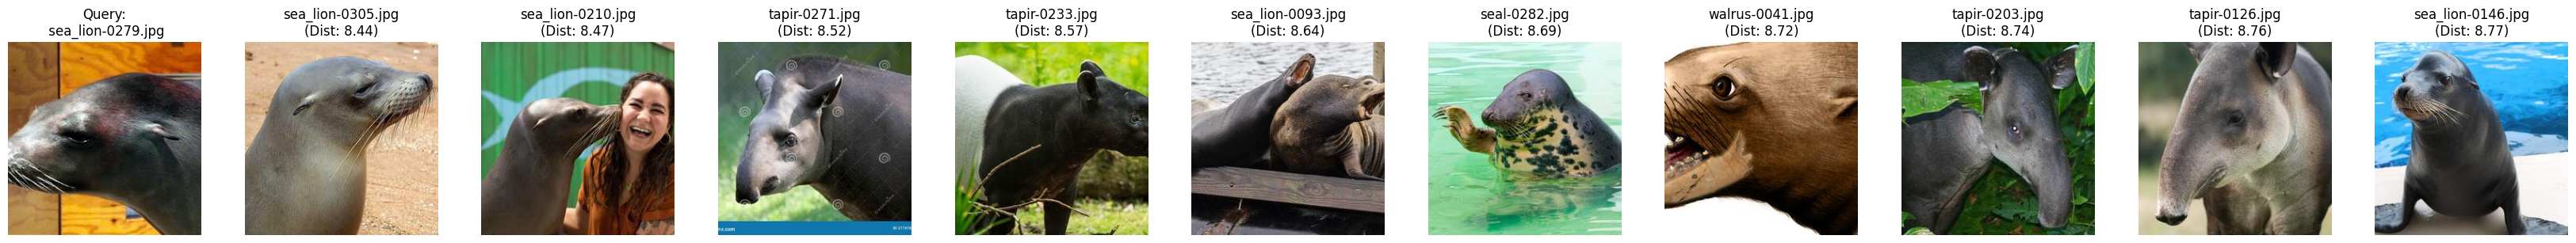

In [40]:
retrieved_indices = print_retrieved_images(train_image_paths, test_image_paths, test_image_indices, indices, distances, return_indices=True)

In [41]:
retrieved_indices

[5593, 5461, 6442, 6471, 5611, 5801, 6883, 6499, 6438, 5560]

All the images are manually flagged as relevant or irrelevant

In [42]:
relevant_indices = [0, 1, 4, 9]  # Manually marked relevant images
irrelevant_indices = [2, 3, 5, 6, 7, 8]   # Manually marked irrelevant images

In [43]:
# Extract relevant and irrelevant train image indices
relevant_indices = [retrieved_indices[i] for i in relevant_indices]
irrelevant_indices = [retrieved_indices[i] for i in irrelevant_indices]

# Print the results
print("Relevant Train Indices:", relevant_indices)
print("Irrelevant Train Indices:", irrelevant_indices)

Relevant Train Indices: [5593, 5461, 5611, 5560]
Irrelevant Train Indices: [6442, 6471, 5801, 6883, 6499, 6438]


An updated query is calculated, by weighting the original query and the relevant/irrelevant images and summing/subtracting the respective feature arrays.

In [44]:
def rocchio_update(query_features, relevant_features, irrelevant_features, alpha=1.0, beta=0.75, gamma=0.15):
    """
    Rocchio algorithm for query refinement.
    - alpha: weight for the original query
    - beta: weight for relevant images
    - gamma: weight for irrelevant images
    """
    relevant_mean = np.mean(relevant_features, axis=0) if len(relevant_features) > 0 else 0
    irrelevant_mean = np.mean(irrelevant_features, axis=0) if len(irrelevant_features) > 0 else 0
    updated_query = alpha * query_features + beta * relevant_mean - gamma * irrelevant_mean
    return updated_query

# Get features for the query image
query_features = combined_test_features[test_image_indices[0]]

# Get features of relevant and irrelevant images
relevant_features = [combined_train_features[i] for i in relevant_indices]
irrelevant_features = [combined_train_features[i] for i in irrelevant_indices]

# Update the query
updated_query = rocchio_update(query_features, relevant_features, irrelevant_features)

In [45]:
updated_query = updated_query.reshape(1, -1)
updated_query.shape

(1, 2560)

In [46]:
distances, indices = kd_tree_combined.query(updated_query, k=10)

Now all the returned images are part of the correct class!

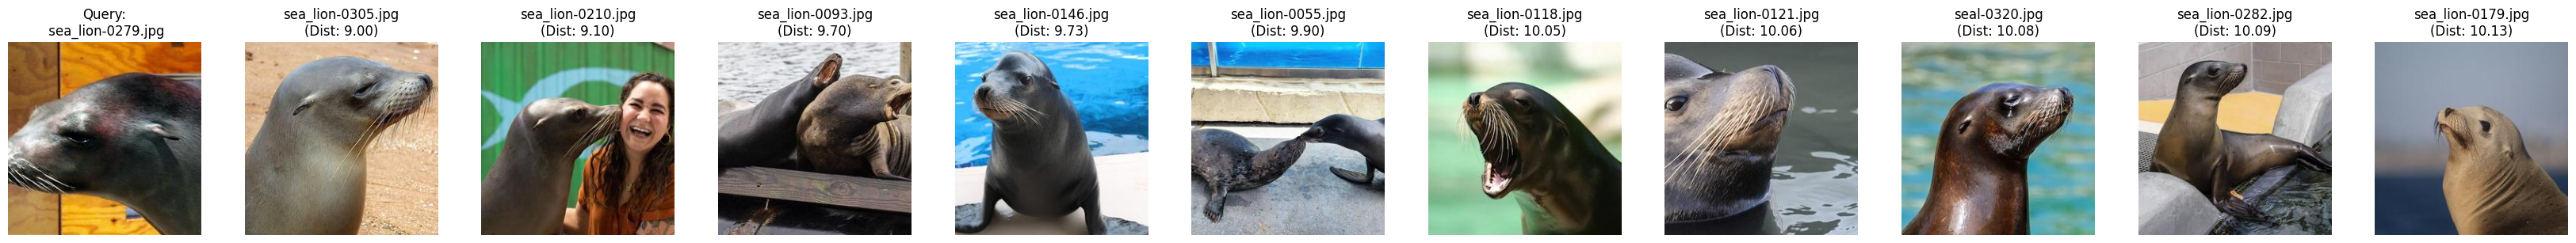

In [47]:
retrieved_indices = print_retrieved_images(train_image_paths, test_image_paths, test_image_indices, indices, distances, return_indices=True)